# ML Modelling

Business case review:
* Ponta Grossa (PG) brewery needs a ML model to predict the beer's color of Amstel. The reason is to allow for interventions on the process, in order to fix the color before it's too late, since color is a key characterisct that defines brand awareness

Modelling specifications:
* There's about 140 rows of useful data, and from the EDA process, no clear relationship between the features were discovered
* This way, I don't expect models to have a good predictive power, but slightly above the average prediction
* From the looks of the data, there's hope of finding non-linear relationships, so I'll use tree-based models due to their state-of-art performance on tabular data
* To avoid overfitting, due to low amount of data, prunning of tree-models will be done
* Some linear models will be used just a baseline, with regularized features to reduce variance

## Modelling outline
* Data loading
* Model pipeline
* Model explanation

In [1]:
#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats

#modelling
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

#processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#other
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

#utils
from src.utils import *

# style options
%matplotlib inline

mpl.style.use('ggplot') 

mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.grid'] = True
mpl.rcParams['font.size'] = 12

pd.set_option('display.max_columns', None)

sns.set_palette('viridis')

%load_ext autoreload
%autoreload 2

c:\Users\ccino\Documents\data_science\case-hnk\venv-case\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

In [2]:
#data loading and slicing amstel subset
df = pd.read_csv('data\\raw_data.csv', index_col=0, parse_dates=['Date/Time'])
df.index.name = ''
df = df.query("""Product=='AMST'""").dropna(subset='Color')
df = df.loc[df['Date/Time'] < pd.to_datetime('2020-11-23')] #remove week with faulty sensor
df.head()

,Job ID,Date/Time,Roast amount (kg),1st malt amount (kg),2nd malt amount (kg),MT - Temperature,MT - Time,WK - Temperature,WK - Steam,WK - Time,Total cold wort,pH,Extract,Color,WOC - Time,WHP Transfer - Time,WHP Rest - Time,Roast color,1st malt color,2nd malt color,Product
,,,,,,,,,,,,,,,,,,,,,
0,2449959642,2020-10-22 02:50:00,64.499934,16051.99658,3999.860052,67.312984,6546.750,105.408559,6482.25,6365.075,958.900,7.296127,15.309445,14.156956,3126.100,729.925,14.494583,908.375,6.1275,6.02,AMST
1,2449959689,2020-10-22 05:44:00,64.500000,16067.85283,4004.256635,66.933041,6889.675,105.303989,6654.25,5929.700,963.200,7.219022,15.285057,14.270939,3135.775,733.150,14.494583,908.375,6.1275,6.02,AMST
2,2449959720,2020-10-22 07:00:00,64.177513,16062.20908,3996.957605,67.177043,6614.475,105.237753,7363.75,6366.150,1088.975,7.182910,14.155171,13.269140,3492.675,912.675,14.494583,908.375,6.1275,6.02,AMST
8,2449961201,2020-10-26 18:46:00,64.392526,NaN,4010.975385,66.901670,6708.000,105.168039,7245.50,7046.625,954.600,NaN,14.656477,18.693288,3630.275,870.750,14.494583,908.375,6.1275,6.02,AMST
9,2449961221,2020-10-26 20:24:00,64.177513,NaN,4012.168750,67.002759,6526.325,105.133183,6686.50,6744.550,964.275,NaN,14.653028,18.176702,3136.850,740.675,14.494583,908.375,6.1275,6.02,AMST


In [3]:
df.columns = fix_headers(df.columns.to_list())
df.columns

Index(['job_id', 'datetime', 'roast_amount_kg', '1st_malt_amount_kg',
       '2nd_malt_amount_kg', 'mt_temperature', 'mt_time', 'wk_temperature',
       'wk_steam', 'wk_time', 'total_cold_wort', 'ph', 'extract', 'color',
       'woc_time', 'whp_transfer_time', 'whp_rest_time', 'roast_color',
       '1st_malt_color', '2nd_malt_color', 'product'],
      dtype='object')

In [4]:
numeric_cols = ['roast_amount_kg', '1st_malt_amount_kg',
       '2nd_malt_amount_kg', 'mt_temperature', 'mt_time', 'wk_temperature',
       'wk_steam', 'wk_time', 'total_cold_wort', 'ph', 'extract',
       'woc_time', 'whp_transfer_time', 'whp_rest_time', 'roast_color',
       '1st_malt_color', '2nd_malt_color']

new_features = [
'base_malt_amount_total',
'malt_amount_total',
'1st_malt_amount_ratio',
'roast_malt_amount_ratio',
'weighted_malt_color_amount_total',
'weighted_malt_color_amount_roast',
'weighted_malt_color_amount_1st',
'mt_cumulative_heat',
'wk_cumulative_heat',
'total_cumulative_heat',
'mt_time_per_amount',
'wk_time_per_amount',
'mt_temperature_per_amount',
'wk_temperature_per_amount',
'whp_transfer_ratio',
'day_of_week',
'is_weekend'
]

target = 'color'

In [5]:
df = fix_dtypes(df, numeric_cols + [target])
df = remove_negative(df, numeric_cols + [target])

In [6]:
df.shape

(139, 21)

In [7]:
df.head()

,job_id,datetime,roast_amount_kg,1st_malt_amount_kg,2nd_malt_amount_kg,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,color,woc_time,whp_transfer_time,whp_rest_time,roast_color,1st_malt_color,2nd_malt_color,product
,,,,,,,,,,,,,,,,,,,,,
0,2449959642,2020-10-22 02:50:00,64.499934,16051.99658,3999.860052,67.312984,6546.750,105.408559,6482.25,6365.075,958.900,7.296127,15.309445,14.156956,3126.100,729.925,14.494583,908.375,6.1275,6.02,AMST
1,2449959689,2020-10-22 05:44:00,64.500000,16067.85283,4004.256635,66.933041,6889.675,105.303989,6654.25,5929.700,963.200,7.219022,15.285057,14.270939,3135.775,733.150,14.494583,908.375,6.1275,6.02,AMST
2,2449959720,2020-10-22 07:00:00,64.177513,16062.20908,3996.957605,67.177043,6614.475,105.237753,7363.75,6366.150,1088.975,7.182910,14.155171,13.269140,3492.675,912.675,14.494583,908.375,6.1275,6.02,AMST
8,2449961201,2020-10-26 18:46:00,64.392526,NaN,4010.975385,66.901670,6708.000,105.168039,7245.50,7046.625,954.600,NaN,14.656477,18.693288,3630.275,870.750,14.494583,908.375,6.1275,6.02,AMST
9,2449961221,2020-10-26 20:24:00,64.177513,NaN,4012.168750,67.002759,6526.325,105.133183,6686.50,6744.550,964.275,NaN,14.653028,18.176702,3136.850,740.675,14.494583,908.375,6.1275,6.02,AMST


## Model pipeline

Two pipelines will be made, one for the linear-based models, and other for the tree-based models, because they need different pre-processing steps. The linear models will be used as baseline to compare them against the tree-based models

In [8]:
np.random.seed(1)
features = numeric_cols + ['datetime']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
pipe_tree_preprocessor = Pipeline(
    [
        ('feature_engineering', PreprocessData(numeric_cols))
    ]
)

cols_linear_preprocessor = ColumnTransformer(
    [
        ('std_scaler', StandardScaler(), numeric_cols+new_features)
    ],
    remainder='passthrough'
)

pipe_linear_preprocessor = Pipeline(
    [
        ('feature_engineering', PreprocessData(numeric_cols)),
        ('preprocessor', cols_linear_preprocessor)
    ]
)

In [10]:
linear_models = [DummyRegressor(strategy='median'), ElasticNet(random_state=1), KNeighborsRegressor()]

params = {'n_estimators': 300, 'random_state': 1, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}

tree_models = [
    RandomForestRegressor(**params),
    GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=2,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=1),
    ExtraTreesRegressor(**params),
    AdaBoostRegressor(n_estimators=500,
                      learning_rate=0.05,
                      loss="square",
                      random_state=1),
    LGBMRegressor()
]

In [11]:
#function to cross-validade multiple models
def cross_validate_models(model_list, X, y):
    scores_df = pd.DataFrame([])
    scoring = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error']
    for model in model_list:
        scores = cross_validate(
            estimator=model,
            X=X,
            y=y,
            scoring=scoring,
            cv=3,
            n_jobs=-1,
            return_train_score=True
        )
        scores_dict = {
            'model_name': model.__class__.__name__,
            'train_r2': scores['train_r2'].mean(),
            'test_r2': scores['test_r2'].mean(),
            'train_MAE': scores['train_neg_mean_absolute_error'].mean(),
            'test_MAE': scores['test_neg_mean_absolute_error'].mean(),
            'train_MAPE': scores['train_neg_mean_absolute_percentage_error'].mean(),
            'test_MAPE': scores['test_neg_mean_absolute_percentage_error'].mean(),
            'train_RMSE': scores['train_neg_root_mean_squared_error'].mean(),
            'test_RMSE': scores['test_neg_root_mean_squared_error'].mean()
        }
        scores_df = pd.concat([scores_df, pd.DataFrame([scores_dict])], axis=0, ignore_index=True)
    return scores_df

In [12]:
#linear models evaluation
X_train_transformed = pipe_linear_preprocessor.fit_transform(X_train)

scores_df = cross_validate_models(linear_models, X_train_transformed, y_train)

scores_df.style.format("{:.3f}", scores_df.columns.to_list()[1:])

,model_name,train_r2,test_r2,train_MAE,test_MAE,train_MAPE,test_MAPE,train_RMSE,test_RMSE
0,DummyRegressor,-0.193,-0.196,-4.793,-4.808,-0.158,-0.159,-10.356,-10.268
1,ElasticNet,0.266,0.180,-5.568,-6.023,-0.288,-0.313,-8.115,-8.497
2,KNeighborsRegressor,0.477,0.218,-4.520,-5.721,-0.247,-0.313,-6.858,-8.299


In [13]:
#tree models evaluation
X_train_transformed = pipe_tree_preprocessor.fit_transform(X_train)

scores_df = cross_validate_models(tree_models, X_train_transformed, y_train)

scores_df.style.format("{:.3f}", scores_df.columns.to_list()[1:])

,model_name,train_r2,test_r2,train_MAE,test_MAE,train_MAPE,test_MAPE,train_RMSE,test_RMSE
0,RandomForestRegressor,0.545,0.233,-4.383,-5.742,-0.226,-0.296,-6.372,-8.217
1,GradientBoostingRegressor,0.985,0.513,-0.825,-4.466,-0.048,-0.239,-1.162,-6.506
2,ExtraTreesRegressor,0.393,0.262,-5.152,-5.677,-0.265,-0.292,-7.382,-8.075
3,AdaBoostRegressor,0.985,0.521,-0.694,-2.949,-0.043,-0.122,-1.144,-6.369
4,LGBMRegressor,0.849,0.504,-2.744,-4.933,-0.158,-0.275,-3.608,-6.616


The models seem to overfit. That's expected since we'are working with just a hundred rows of data and the feature's aren't good at identifying the target variable, so the trees learns the noise on training data.

* As this is synthetic data, I'll just follow with the AdaBoostRegressor model because it has the best test R2 score and lowest MAE among the tree models. 

### Final model evaluation

* for the final evaluation, I'll use AdaBoost with all the train data and evaluate it's performance against the test set

In [14]:
model = AdaBoostRegressor(n_estimators=500,
                      learning_rate=0.05,
                      loss="square",
                      random_state=1)

model.fit(X_train_transformed, y_train)

,estimator,None
,n_estimators,500
,learning_rate,0.05
,loss,'square'
,random_state,1


In [15]:
X_test_transformed = pipe_tree_preprocessor.transform(X_test)

train_r2 = model.score(X_train_transformed, y_train)
test_r2 = model.score(X_test_transformed, y_test)

print(f'Train R2: {train_r2:.3f}')
print(f'Test R2: {test_r2:.3f}')

Train R2: 0.981
Test R2: 0.862


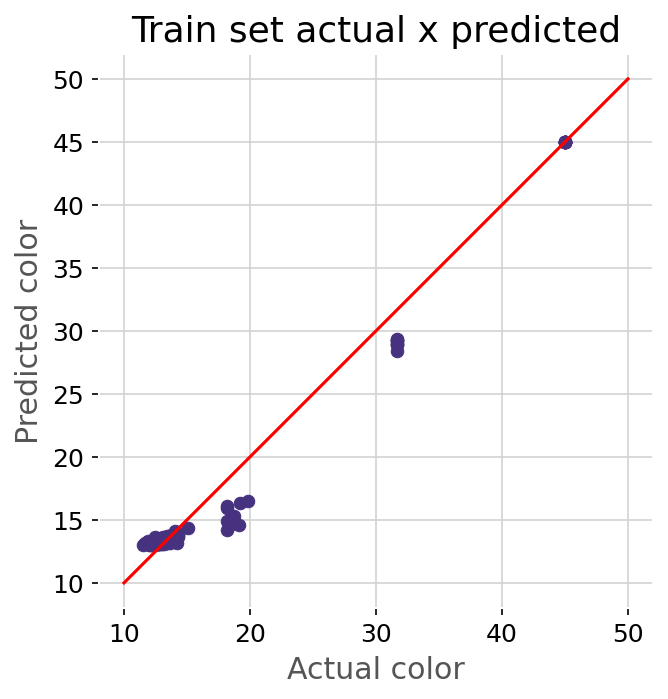

In [16]:
#now let's plot the predictions against the real values
y_pred_train = model.predict(X_train_transformed)
plt.scatter(y_train, y_pred_train)
plt.xlabel('Actual color')
plt.ylabel('Predicted color')
plt.title('Train set actual x predicted')
plt.gca().set_aspect('equal')
plt.plot([10, 50], [10, 50], color='red')

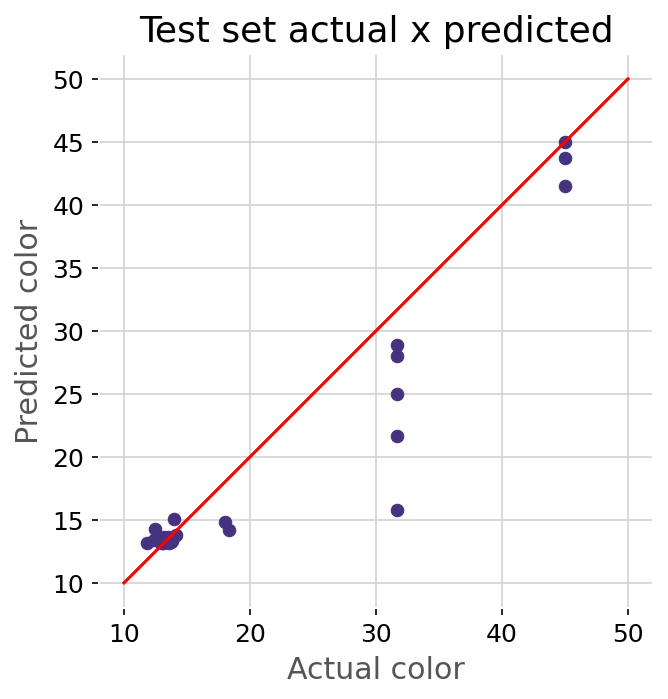

In [17]:
#test set
y_pred_test = model.predict(X_test_transformed)
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual color')
plt.ylabel('Predicted color')
plt.title('Test set actual x predicted')
plt.gca().set_aspect('equal')
plt.plot([10, 50], [10, 50], color='red')

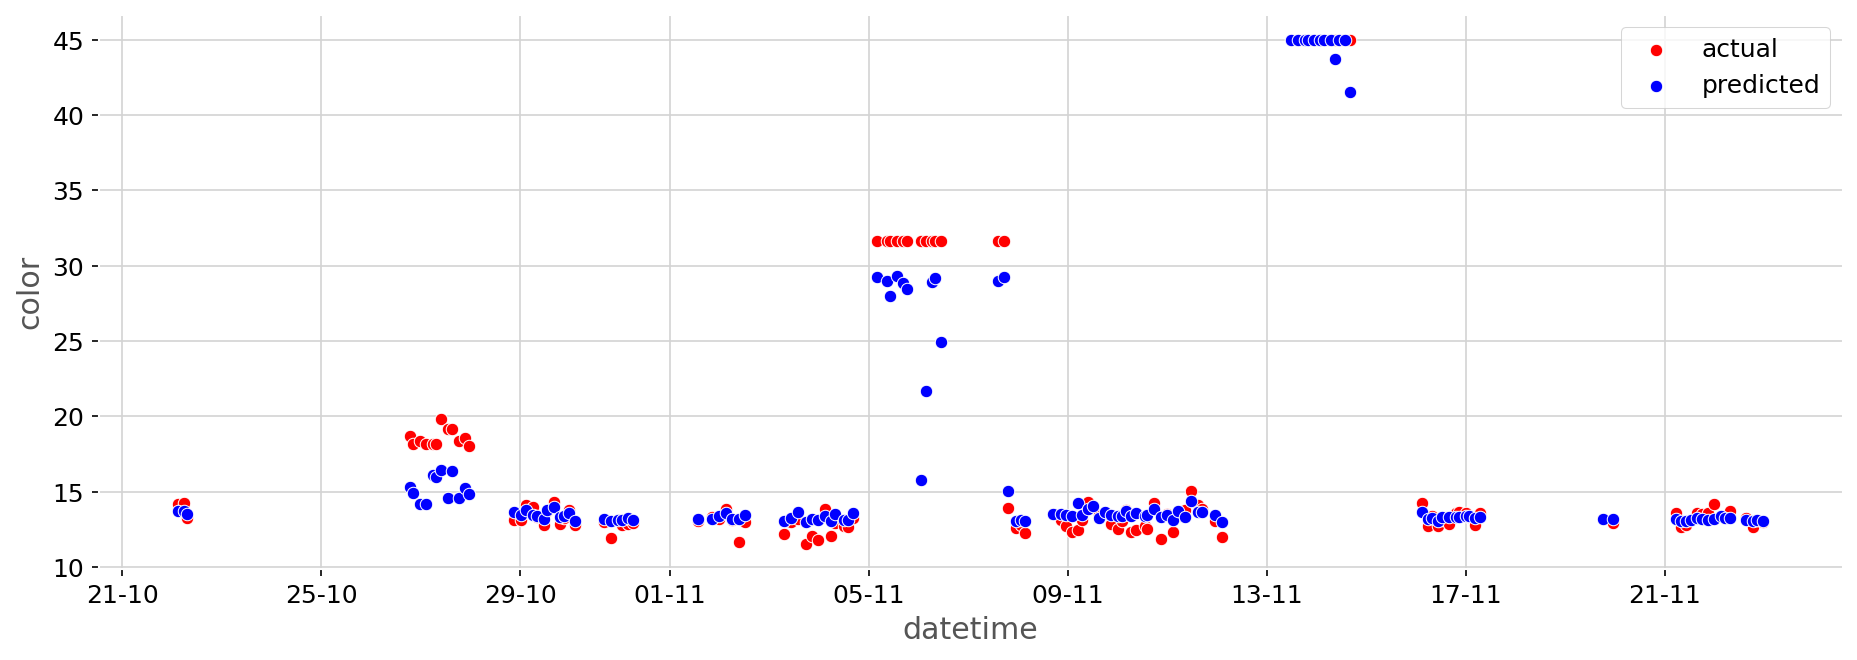

In [18]:
date_formatter = mpl.dates.DateFormatter('%d-%m')

df_transformed = pipe_tree_preprocessor.transform(df[features])
y_pred_df = model.predict(df_transformed)

sns.scatterplot(data=df, x='datetime', y='color', color='red', label='actual')
sns.scatterplot(x=df['datetime'], y=y_pred_df, color='blue', label='predicted')


plt.gca().xaxis.set_major_formatter(date_formatter)
plt.gcf().set_figwidth(15)

### Model explanation

* In this section, the SHAP library will be used to assess the importance of some features to the model

In [19]:
explainer = shap.Explainer(model.predict, X_test_transformed)

In [20]:
shap_values = explainer(X_test_transformed)

PermutationExplainer explainer: 29it [00:25,  1.12s/it]                        


In [21]:
shap_values.shape, X_test_transformed.shape

((28, 34), (28, 34))

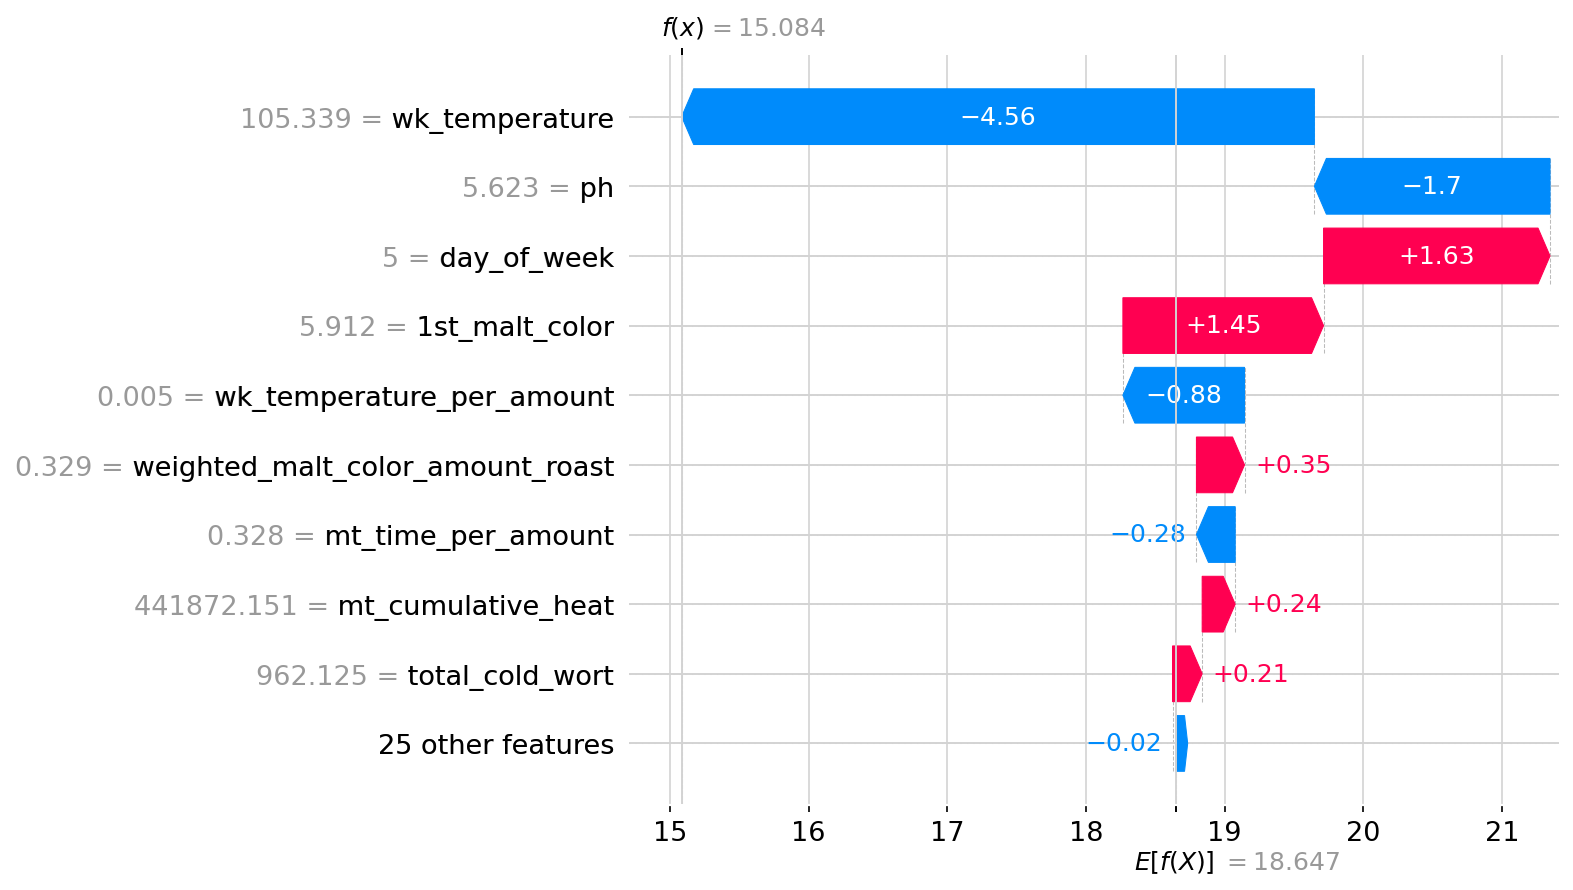

In [22]:
shap.plots.waterfall(shap_values[0])

For this particular sample, we can see how much each feature influenced in the beer color. It's good to see many of the engineered features appearing here.
* Features from the hot phase are the most important features in this model, just like the empirical brewing knowledge

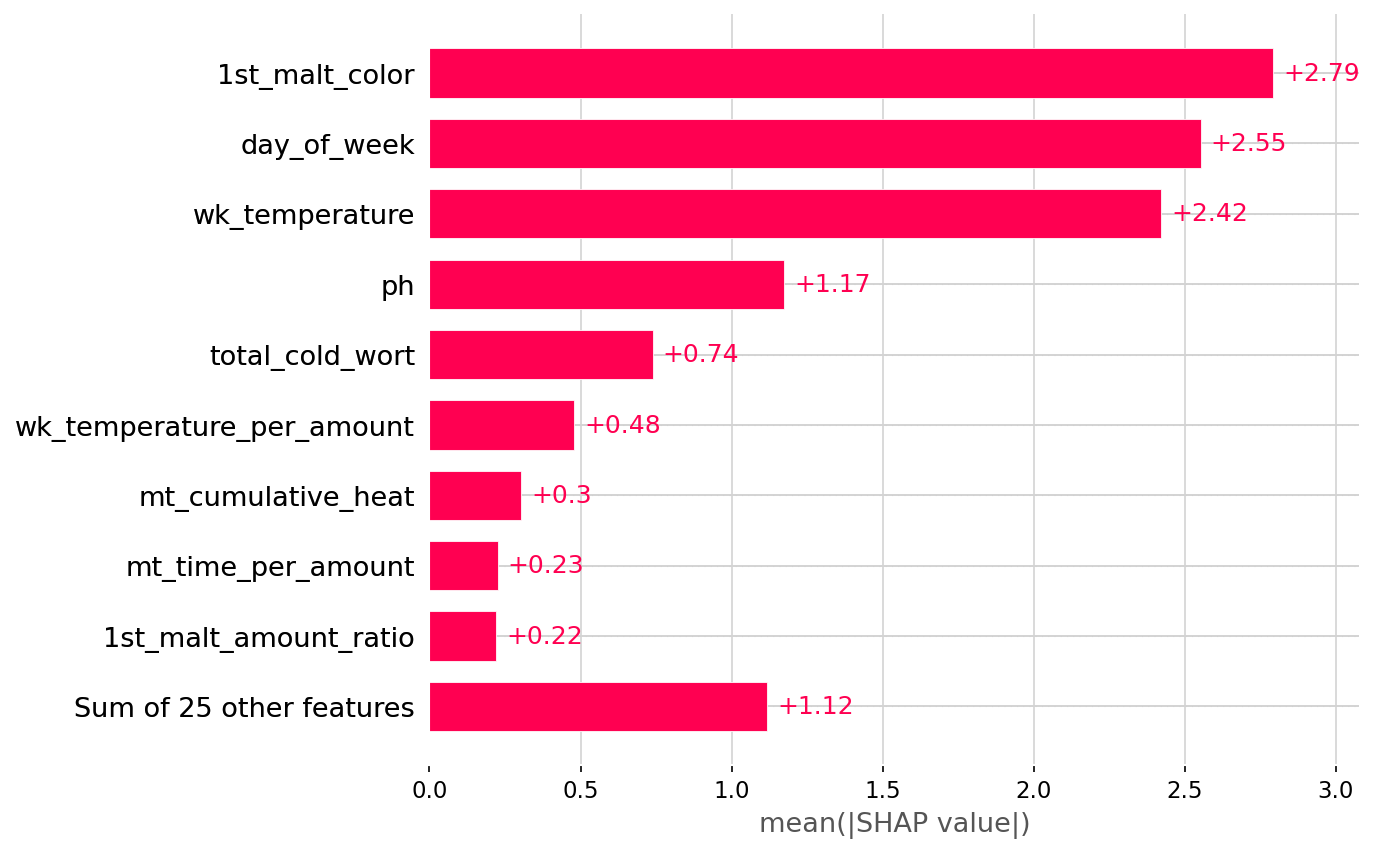

In [23]:
shap.plots.bar(shap_values)

* On average, 1st malt color influences the most the final beer's color
* For my surprise, the roast related features didn't appear in the top 10 most important features
* Perhaps there's a kind of operational drift regarding the day of week. Depending on the day, different batches of colors are made

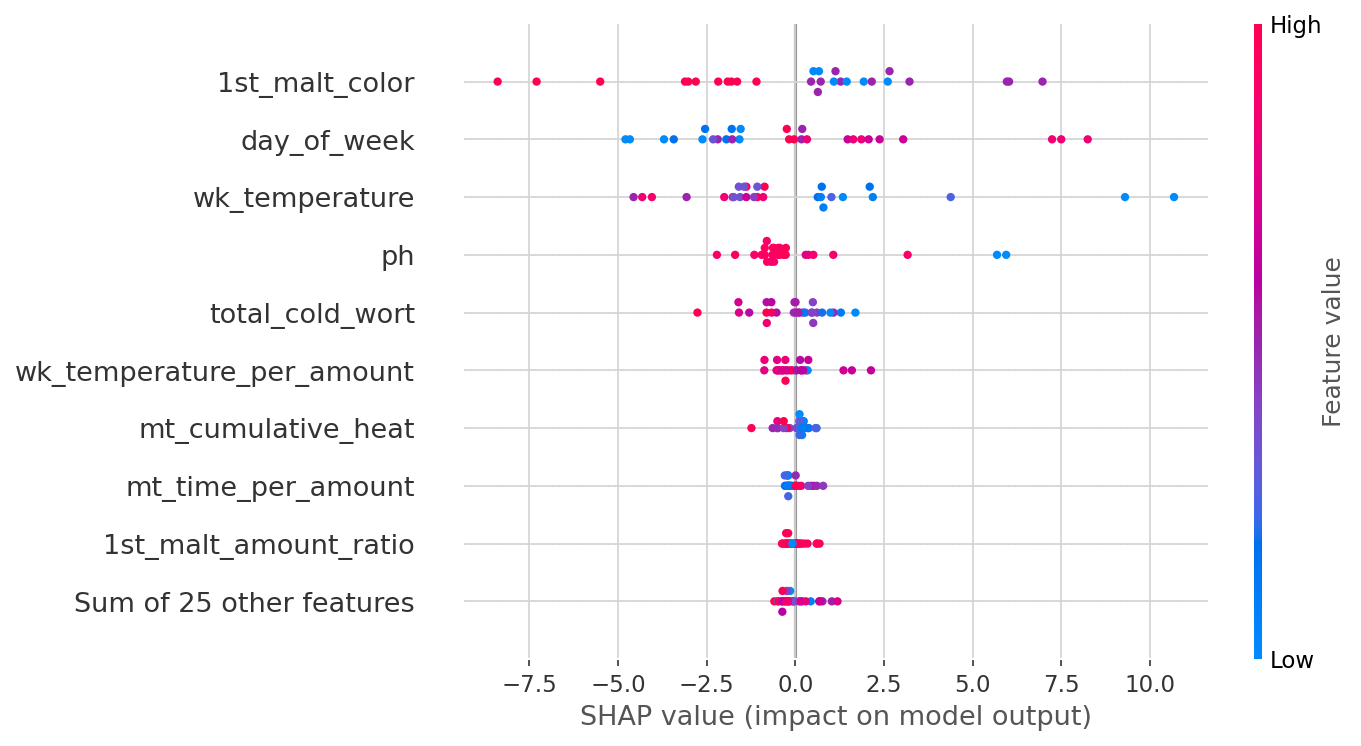

In [24]:
shap.plots.beeswarm(shap_values)

* Higher values of 1st malt color helps to decrease the final beer color. This is counter-intuitive, since we expected the higher values to yield darker colors
* The same can be said about the wort cooker temperature, higher values makes the beer colors lighter (considering that low values of color EBC = lighter colors)

## Next steps:
Prediction process:
* The idea is, since the features will be filled sequentially, as the machinery runs in the brewery, a model will be trained to predict the color of the beer as early as possible. Only a couple of features will be given to the model, while the remaing features (later stages of the process) will be imputed with the previous batches median. We can see in the SHAP values that some early features appears as most important, so this may be feasible

Color optimization step:
* After prediction, a recommendation will be given to attempt to fix the beer's color with a 'what-if' analysis. This will be done using SHAP values, much like the coefficients of a linear regression.